# ROC曲線，AUCを用いてモデルの精度を評価する(2022/02/11)
---

## 概要
---
本notebookでは，モデルの制度を評価するためのROC(Receiver Operating Characteristic)曲線と，AUC(Area Under the Curve)について調査し，シミュレーションを行う．

要点をまとめると以下の通り．
- ROC曲線とAUCは二値分類モデルについて性能評価を行う指標
- ROC曲線は急峻であるほど良く，AUCは1に近いほど(大きい値であるほど)良い



## 二値分類モデル
---
ROC曲線とAUCについて述べる前に，評価の対象である二値分類モデルについて説明する．

二値分類モデルとは，その名の通り二値(0, 1)で分類を行うモデルのことである．つまり，あるデータセットを2つに分けるモデルということになる．例えば，「数ある写真の中から人が映り込んでいるものとそうでないものとを分ける」というのは二値分類であるし，「ヒトの集団の中から新型コロナウイルス感染症陽性患者を見つける」というのも二値分類に相当する．

二値分類モデルでは入力として分類対称のデータを与えると，出力として0から1の値を出力する．この値に対して予め閾値を設定しておくことで，0か1か，負例か正例かの判別が可能になる．データセットにはあらかじめどちらのグループに属するかラベル付けが必要であり，モデルはこれに基づいて教師あり学習を行うことになる．

蛇足だが，データセットに対して0(負例，陰性), 1(正例，陽性)どちらがどちらのラベルを付けるのかは自由である．つまり，分類モデルからすれば判別だけできれば良いということである．ただ慣習として，検出したい事物を含むデータに対して1(正例，陽性)が割り当てられることが多い．例えば，コロナウイルス感染者を検出する二値分類モデルを構築しようと考えた場合には，訓練データセットの陽性患者に対してラベル1を割り当てることが多い．

## 真陽性率(TPR)と偽陽性率(FPR)
---
真陽性率(True Positive Rate)と偽陽性率(False Positive Rate)は，昨今の新型コロナウイルス感染症蔓延の影響で巷でも聞くことが多くなった．ROC曲線を描くために必要な指標であるあるから，これらについても予め説明する．

真陽性率とは，集団の中で陽性であるデータのうち，分類モデルが実際に陽性だと判定したデータの割合のことである．

\begin{eqnarray}
TPR = \frac{TP}{TP + FN}
\end{eqnarray}

TP(True Positive)とは陽性データのうち分類モデルが陽性だと判定したデータの数で，FN(False Negative)は陽性データのうち分類モデルが誤って陰性だと判定したデータの数を表す．TPが多く，FNが少ないのが理想であるから，TPRは1に近い値をとるほど良いということになる．

また，偽陽性率とは，集団の中で陰性であるデータのうち，分類モデルが誤って陽性だと判定したデータの割合のことである．

\begin{eqnarray}
FPR = \frac{FP}{FP + TN}
\end{eqnarray}

FP(False Positive)とは陰性データのうち分類モデルが誤って陽性だと判定したデータの数であり，TN(True Negative)は陰性データのうち分類モデルが実際に陰性だと判定したデータの数である．FPが少なく，TNが多いのが理想であるから，FPRは0に近い値をとるほど良いということになる．

## ROC曲線
---
ROC曲線とは二値分類モデルの性能を評価するための指標の一つである．縦軸を真陽性率(True Positive Rate)，横軸を偽陽性率(False Positive Rate)としてモデルの閾値を変えながら曲線を描く．

先述の通りTPRは1に近く，FPRは0に近いことが理想であるから，分類を間違えなかったモデルの場合にはROC曲線はもはや曲線ではなく直角の折れ線になる．

文章で記述しても直感的な理解が難しいので，後述のシミュレーションで理解するのが良いと感じる．

## AUC
---
AUCはArea Under the Curveという名の通り，曲線下の面積のことである．この曲線とは何かというとROC曲線のことである．

ROC曲線の定義域と値域はどちらも0から1であり，最良のモデルで直角の折れ線，最低のモデル(つまり当て推量)で傾き1の直線になることから，AUCは0.5から1.0の値をとる．つまり0.5が最悪で，1.0が最良の二値分類モデルという解釈になる．

ROC曲線は直感的に分類モデルの性能を評価できる一方，AUCは定量的にモデルの性能を評価できる．

## Pythonを用いたシミュレーション
---
今回はBrest Cancer Wisconsinという肺癌患者のデータセットを用いて，腫瘍が良性か悪性か判定する分類モデルを構築する．

具体的にはロジスティック回帰モデルを構築し，交差検証法でいくつかデータを採取しながら平均的なROC曲線を描画する．そしてAUCも求めていく．

In [1]:
# Brest Cancer Wisconsinデータセットの読み込み
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


公式ドキュメントやData Frameを見ると分かるように，0番目の列が患者のIDであり，1番目の列がラベルになっている．Mが悪性(malignant)で，Bが良性(benign)である．また，2番目以降の列はすべて実数値の特徴量になっている．

In [2]:
# 特徴量とラベルに分割
# また，ラベルが文字列で与えられているため，バイナリ値に変換しておく
from sklearn.preprocessing import LabelEncoder

X = df.loc[:,2:].values
y = df.loc[:,1].values

le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
# 訓練データとテストデータに分割
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

In [4]:
# データの標準化・主成分分析・ロジスティック回帰を行うパイプラインを構築
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                       LogisticRegression(penalty='l2', random_state=1, C=100.0))

In [5]:
# 特徴量を2つに絞る(恣意的に精度を落として，ROC曲線を分かりやすくする)
X_train2 = X_train[:,[4, 14]]
X_test2 = X_test[:,[4, 14]]

In [6]:
# ROC曲線とAUCをプロット
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,5))

<Figure size 504x360 with 0 Axes>

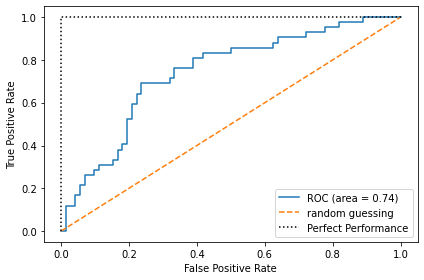

In [7]:
probas = pipe_lr.fit(X_train2, y_train).predict_proba(X_test2)
fpr, tpr, thresholds = roc_curve(y_test, probas[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC (area = %0.2f)' % roc_auc)
    

# 当て推量
plt.plot([0,1], [0,1], linestyle='--', label='random guessing')

# 理想的なモデル
plt.plot([0,0,1], [0,1,1], linestyle=':', color='black', label='Perfect Performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## 参考文献
---

[Breast Cancer Wisconsin (Diagnostic) Data Set，UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic))

[sklearn.preprocessing.LabelEncoder，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

[sklearn.model_selection.train_test_split，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

[sklearn.preprocessing.StandardScaler，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

[sklearn.decomposition.PCA，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

[sklearn.linear_model.LogisticRegression，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[sklearn.pipeline.make_pipeline，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)

[sklearn.metrics.roc_curve，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)

[sklearn.metrics.auc，scikit-learn 1.0.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html)